In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from tqdm import tqdm
from scipy.special import logsumexp
from scipy.stats import multivariate_normal, multivariate_t, random_correlation
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

from emukit.core import ContinuousParameter, InformationSourceParameter, ParameterSpace
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, MaxValueEntropySearch, NegativeLowerConfidenceBound
import GPy
from emukit.core.initial_designs.latin_design import LatinDesign
from functools import partial

# Enable LaTeX for nicer plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


In [2]:
def AMIS_fixed_dof(mu_initial,shape_initial, n_iterations, log_pi_tilde, dof_proposal, M, D):
    
    alpha = 1 + 2 / (dof_proposal + D) #to be used for computation of the alpha-ESS
    
    all_samples = np.empty((n_iterations,M,D))
    evaluations_target_logpdf = np.empty((n_iterations,M))
    mixture_denominator_evaluations = np.empty((n_iterations,M))
    proposals_over_iterations = []

    all_estimate_Z = np.empty(n_iterations)
    all_ESS = np.empty(n_iterations)
    all_alphaESS = np.empty(n_iterations)

    mu_current = mu_initial
    shape_current = shape_initial
    
    # Iterations
    for t in range(n_iterations):
        
        current_proposal = multivariate_t(loc=mu_current, shape=shape_current, df=dof_proposal)
        proposals_over_iterations.append(current_proposal)

        # Draw M samples from current proposal
        samples_current = np.transpose([current_proposal.rvs(size=M)])
        all_samples[t,:] = samples_current # this adds to the existing list of samples, does not override

        

        # Numerator
        for m in range(M):
            evaluations_target_logpdf[t,m] = log_pi_tilde(samples_current[m,:])#log_pi_tilde may not be broasdact-compatible

        log_numerator = evaluations_target_logpdf[:t+1,:] # t+1 since including current ones !

        
        # Computing the DM weights in the denominator
        current_only_log_denominator = current_proposal.logpdf(samples_current)
        mixture_denominator_evaluations[t,:] = np.exp(current_only_log_denominator)
        
        for tau in range(t):
            #this loop is only entered if t>0
            mixture_denominator_evaluations[tau,:] += np.exp(current_proposal.logpdf(all_samples[tau,:]))
            mixture_denominator_evaluations[t,:] += np.exp(proposals_over_iterations[tau].logpdf(samples_current))
        
        log_denominator = - np.log(t+1) +  np.log(mixture_denominator_evaluations[:t+1,:])

        assert log_numerator.shape == log_denominator.shape

        updated_logweights = log_numerator - log_denominator
        logsumexp_logweights = logsumexp(updated_logweights)
        updated_normalized_logweights = updated_logweights - logsumexp_logweights
        
        ### Estimate of the normalization constant
        estimate_Z = np.exp(logsumexp_logweights) / (M*(t+1))
        all_estimate_Z[t] = estimate_Z

        
        ### metrics 
        current_only_logweights = evaluations_target_logpdf[t,:] - current_only_log_denominator
        current_only_normalized_logweights = current_only_logweights - logsumexp(current_only_logweights)

        current_only_alphaESS = np.exp(logsumexp(alpha*current_only_normalized_logweights))**(1 / (1-alpha))
        current_only_ESS = 1 / np.exp(logsumexp(2*current_only_normalized_logweights))
        
        all_alphaESS[t] = (1/M)*current_only_alphaESS
        all_ESS[t] = (1/M)*current_only_ESS
        
        ### Update proposal
        
        samples_up_to_now = all_samples[:t+1,:,:]

        # Standard moment matching
        W = np.exp(updated_normalized_logweights)
        mu_current = np.einsum('tmd,tm->d', samples_up_to_now, W)
        secnd_moment = np.einsum('tm, tmd, tme -> de', W, samples_up_to_now, samples_up_to_now)
        shape_current = ((dof_proposal - 2) / dof_proposal) * ( secnd_moment - mu_current.reshape(-1, 1) @ mu_current.reshape(1, -1) )

    return multivariate_t(loc=mu_current, shape=shape_current, df=dof_proposal)

In [3]:
def escortAMIS_fixed_dof(mu_initial,shape_initial, n_iterations, log_pi_tilde, dof_proposal, M, D):
    
    alpha = 1 + 2 / (dof_proposal + D) #to be used for computation of the alpha-ESS
    
    all_samples = np.empty((n_iterations,M,D))
    evaluations_target_logpdf = np.empty((n_iterations,M))
    mixture_denominator_evaluations = np.empty((n_iterations,M))
    proposals_over_iterations = []
    # Statistics to track
    all_estimate_Z = np.empty(n_iterations)
    all_ESS = np.empty(n_iterations)
    all_alphaESS = np.empty(n_iterations)

    mu_current = mu_initial
    shape_current = shape_initial
    
    # Iterations
    for t in range(n_iterations):
        current_proposal = multivariate_t(loc=mu_current, shape=shape_current, df=dof_proposal)
        proposals_over_iterations.append(current_proposal)

        # Draw M samples from current proposal
        samples_current = np.transpose([current_proposal.rvs(size=M)])
        all_samples[t,:] = samples_current # this adds to the existing list of samples, does not override

        # Numerator
        for m in range(M):
            evaluations_target_logpdf[t,m] = log_pi_tilde(samples_current[m,:])# log_pi_tilde may not be broasdact-compatible

        log_numerator = evaluations_target_logpdf[:t+1,:] # t+1 since including current ones !

        
        # Computing the DM weights in the denominator
        current_only_log_denominator = current_proposal.logpdf(samples_current)
        mixture_denominator_evaluations[t,:] = np.exp(current_only_log_denominator)
        
        for tau in range(t):
            #this loop is only entered if t>0
            mixture_denominator_evaluations[tau,:] += np.exp(current_proposal.logpdf(all_samples[tau,:]))
            mixture_denominator_evaluations[t,:] += np.exp(proposals_over_iterations[tau].logpdf(samples_current))
        
        log_denominator = - np.log(t+1) +  np.log(mixture_denominator_evaluations[:t+1,:])

        assert log_numerator.shape == log_denominator.shape

        updated_logweights = log_numerator - log_denominator
        logsumexp_logweights = logsumexp(updated_logweights)
        updated_normalized_logweights = updated_logweights - logsumexp_logweights
        
        
        ### Estimate of the normalization constant
        estimate_Z = np.exp(logsumexp_logweights) / (M*(t+1)) # weights need to have only pi_tilde in the numerator (no escort) 
        all_estimate_Z[t] = estimate_Z

        ### metrics 
        current_only_logweights = evaluations_target_logpdf[t,:] - current_only_log_denominator 
        current_only_normalized_logweights = current_only_logweights - logsumexp(current_only_logweights) 

        # weights need to have only pi_tilde in the numerator (no escort)
        current_only_alphaESS = np.exp(logsumexp(alpha*current_only_normalized_logweights))**(1 / (1-alpha))
        current_only_ESS = 1 / np.exp(logsumexp(2*current_only_normalized_logweights))
        
        all_alphaESS[t] = (1/M)*current_only_alphaESS
        all_ESS[t] = (1/M)*current_only_ESS
        
        ### Update proposal
        
        samples_up_to_now = all_samples[:t+1,:,:]

        # weights need to have the escort of pi_tilde in the numerator
        updated_escort_logweights = alpha*log_numerator - log_denominator
        updated_normalized_escort_logweights = updated_escort_logweights - logsumexp(updated_escort_logweights)

        W = np.exp(updated_normalized_escort_logweights)
        mu_current = np.einsum('tmd,tm->d', samples_up_to_now, W)
        secnd_moment =  np.einsum('tm, tmd, tme -> de', W, samples_up_to_now, samples_up_to_now)
        shape_current = secnd_moment - (mu_current.reshape(-1, 1) @ mu_current.reshape(1, -1))

    return multivariate_t(loc=mu_current, shape=shape_current, df=dof_proposal)

In [4]:
def escortAMIS_adapted_dof(mu_initial, shape_initial, n_iterations, log_pi_tilde, dof_initial, M, D):

    all_samples = np.empty((n_iterations, M, D))
    evaluations_target_logpdf = np.empty((n_iterations, M))
    mixture_denominator_evaluations = np.empty((n_iterations, M))
    proposals_over_iterations = []

    # Statistics to track
    all_estimate_Z = np.empty(n_iterations)
    all_ESS = np.empty(n_iterations)
    all_alphaESS = np.empty(n_iterations)
    all_dof = np.empty(n_iterations)

    gpy_model = None
    emukit_model = None

    # Range DOF from 1 to 10
    dof_proposal_space = ParameterSpace([ContinuousParameter('dof_proposal', 1, 10)])
    num_initial_dof_points = 5


    observed_dof = np.array([])
    observed_ess = np.array([])

    mu_current = mu_initial
    shape_current = shape_initial
    dof_proposal = dof_initial

    # Initial points
    latin_design = LatinDesign(dof_proposal_space)
    initial_dof_points = latin_design.get_samples(num_initial_dof_points)

    # Iterations
    for t in range(n_iterations):


        # adaptation of the dof
        if t>0:

            if t < num_initial_dof_points :
                dof_proposal = initial_dof_points[t].item()
            else:
                if gpy_model is None:
                    #declare model
                    gpy_model = GPy.models.GPRegression(observed_dof.reshape(-1,1), observed_ess.reshape(-1,1))
                    emukit_model = GPyModelWrapper(gpy_model)
          
                else:
                    emukit_model.set_data(observed_dof.reshape(-1,1), observed_ess.reshape(-1,1))#update

                beta_param = 2 * np.log((t**2 + 1)*10 / np.sqrt(2*np.pi)) #from Garnett2023 p 229
                
                acquisition = NegativeLowerConfidenceBound(emukit_model, beta=beta_param) #high beta => exploration, while small beta => exploitation
                
                optimizer = GradientAcquisitionOptimizer(dof_proposal_space)
                x_new, _ = optimizer.optimize(acquisition)
                
                dof_proposal = x_new.item()

        alpha = 1 + 2 / (dof_proposal + D)


        # adaptation of mu and shape
        if t > 0:

            updated_escort_logweights = alpha * log_numerator - log_denominator # weights need to have the escort of pi_tilde in the numerator
            updated_normalized_escort_logweights = updated_escort_logweights - logsumexp(updated_escort_logweights)

            W = np.exp(updated_normalized_escort_logweights)
            mu_current = np.einsum('tmd,tm->d', samples_up_to_now, W)
            secnd_moment = np.einsum('tm, tmd, tme -> de', W, samples_up_to_now, samples_up_to_now)
            shape_current = secnd_moment - (mu_current.reshape(-1, 1) @ mu_current.reshape(1, -1))

        # sampling and computing of the ESS

        current_proposal = multivariate_t(loc=mu_current, shape=shape_current, df=dof_proposal)
        proposals_over_iterations.append(current_proposal)

        samples_current = np.transpose([current_proposal.rvs(size=M)]) # Draw M samples from current proposal
        all_samples[t, :] = samples_current  # this adds to the existing list of samples, does not override
        samples_up_to_now = all_samples[:t + 1, :, :]

        # Numerator
        for m in range(M):
            evaluations_target_logpdf[t, m] = log_pi_tilde(samples_current[m, :])  # log_pi_tilde may not be broasdact-compatible

        log_numerator = evaluations_target_logpdf[:t + 1, :]  # t+1 since including current ones !

        # Computing the DM weights in the denominator
        current_only_log_denominator = current_proposal.logpdf(samples_current)
        mixture_denominator_evaluations[t, :] = np.exp(current_only_log_denominator)

        for tau in range(t):
            # this loop is only entered if t>0
            mixture_denominator_evaluations[tau, :] += np.exp(current_proposal.logpdf(all_samples[tau, :]))
            mixture_denominator_evaluations[t, :] += np.exp(proposals_over_iterations[tau].logpdf(samples_current))

        log_denominator = - np.log(t + 1) + np.log(mixture_denominator_evaluations[:t + 1, :])


        # Computing Z and the ESS

        updated_logweights = log_numerator - log_denominator
        logsumexp_logweights = logsumexp(updated_logweights)
        updated_normalized_logweights = updated_logweights - logsumexp_logweights

        estimate_Z = np.exp(logsumexp_logweights) / (M * (t + 1))  # weights need to have only pi_tilde in the numerator (no escort)
        all_estimate_Z[t] = estimate_Z

        current_only_logweights = evaluations_target_logpdf[t, :] - current_only_log_denominator
        current_only_normalized_logweights = current_only_logweights - logsumexp(current_only_logweights)

        current_only_alphaESS = np.exp(logsumexp(alpha * current_only_normalized_logweights)) ** (1 / (1 - alpha))
        current_only_ESS = 1 / np.exp(logsumexp(2 * current_only_normalized_logweights))

        if t>0:
            observed_dof = np.append(observed_dof, np.array([dof_proposal]), axis=0)
            observed_ess = np.append(observed_ess, np.array([np.log(1 -(1 / M) * current_only_alphaESS)]), axis=0)
            
        all_alphaESS[t] = (1 / M) * current_only_alphaESS
        all_ESS[t] = (1 / M) * current_only_ESS
        all_dof[t] = dof_proposal


    return multivariate_t(loc=mu_current, shape=shape_current, df=dof_proposal)

In [5]:
dof_target = 1
target = multivariate_t([0.0], [1.0], dof_target)

In [6]:
mu_initial = np.array(multivariate_normal([0.0], [1.0]).rvs())
shape_initial = np.array([5.0])
n_iterations = 20
log_pi_tilde = target.logpdf
dof_proposal = 3
M = 10000
D = 1
mu_initial

array(0.29726462)

In [7]:
proposal_1 = AMIS_fixed_dof(mu_initial,shape_initial, n_iterations, log_pi_tilde, dof_proposal, M, D)

In [8]:
proposal_2 = escortAMIS_fixed_dof(mu_initial,shape_initial, n_iterations, log_pi_tilde, dof_proposal, M, D)

In [9]:
proposal_3 = escortAMIS_adapted_dof(mu_initial,shape_initial, n_iterations, log_pi_tilde, dof_proposal, M, D)

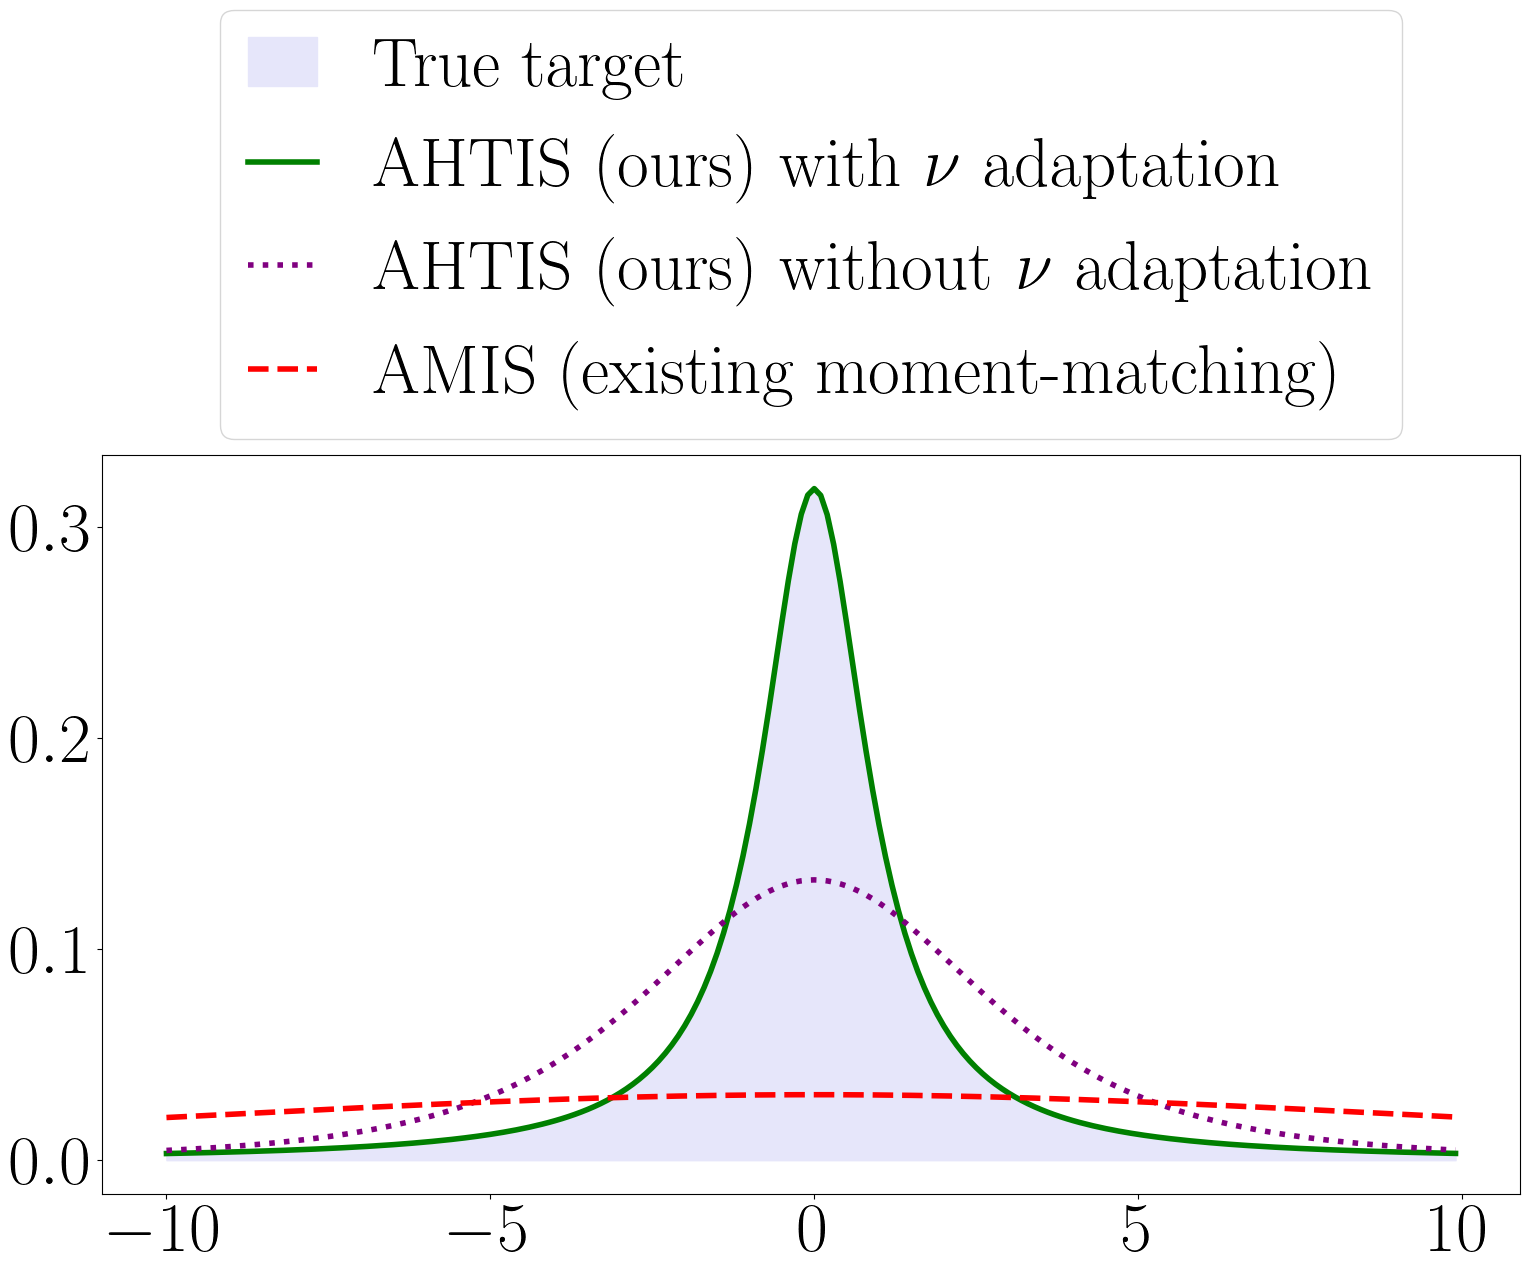

In [40]:
plt.rc('font', family='serif', size=30)
# plt.rc('axes', labelsize=25, titlesize=20, labelpad=20)  # Adjusting axes parameters
plt.rc('xtick', labelsize=50)  # Adjusting xtick parameters
plt.rc('ytick', labelsize=50)  # Adjusting ytick parameters
plt.rc('legend', fontsize=50)  # Adjusting legend parameters
plt.rc('legend', handlelength=1)  # e.g., shorter lines
plt.rc('figure', figsize=(16, 9))

#plotting
x = np.arange(-10.0, 10.0, 0.1)
fig = plt.figure()
plt.fill_between(x, target.pdf(x), label=r'True target', color='lavender')
plt.plot(x, proposal_3.pdf(x), label=r'AHTIS (ours) with $\nu$ adaptation', color='green', linewidth=4, linestyle='-')
plt.plot(x, proposal_2.pdf(x), label=r'AHTIS (ours) without $\nu$ adaptation', color='purple', linewidth=4, linestyle=':')
plt.plot(x, proposal_1.pdf(x), label=r'AMIS (existing moment-matching)', color='red', linewidth=4, linestyle='--')

# plt.subplots_adjust(top=0.8)  # Adjust the top subplot parameter

plt.tight_layout()
# plt.legend(loc='upper left')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.65), ncol=1)

plt.savefig("oneDimensionalComparisonPlot.pdf",bbox_inches="tight")